## This notebook covers:
# The Machine Learning Workflow
## Preprocessing, Pipeline, Cross Validation, Model Selection and Interpretation

## 📚 <font color='steelblue'>Part 0:</font> Modules 📚

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as ms

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m
from sklearn.metrics import confusion_matrix

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

## 💻 <font color='steelblue'>Part 1:</font> Load and Split Data 💻

In [2]:
# Set seed for reproducibility
set_seed = 111111

In [3]:
# Load HURDAT2 observation dataframe, complete with SST variable
dat = pd.read_pickle("HURDAT2_with_SST.pkl")
dat.shape # display shape

(52717, 23)

In [4]:
# Display a sample of rows
dat.sample(n = 5)

,Storm_Identifier,Storm_Name,Record,Status,Lat,Lon,Wind,Pressure,DateTime,YearDay,...,Speed,Category,34kt_radius,50kt_radius,64kt_radius,Rapid_NHC24,Outcome_Total,Outcome_Switch,Outcome_HoursToRapid,SST
20199,AL101943,UNNAMED,,TS,17.4,-87.0,35,-999,1943-10-24 18:00:00,297,...,4.882560,0,-999.0,-999.0,-999.0,False,False,False,NaN,NaN
11535,AL081908,UNNAMED,,HU,18.1,-72.2,70,-999,1908-09-28 06:00:00,272,...,7.586623,1,-999.0,-999.0,-999.0,False,False,False,NaN,NaN
7792,AL061894,UNNAMED,,HU,18.7,-65.2,85,-999,1894-10-14 06:00:00,287,...,6.622419,2,-999.0,-999.0,-999.0,False,False,False,NaN,NaN
19588,AL031941,UNNAMED,,HU,29.9,-72.4,65,-999,1941-09-22 00:00:00,265,...,9.579582,1,-999.0,-999.0,-999.0,False,False,False,NaN,NaN
31760,AL101974,CARMEN,,HU,18.4,-86.8,130,928,1974-09-02 06:00:00,245,...,9.448947,4,-999.0,-999.0,-999.0,True,True,False,0.0,NaN


In the sample of above, there are several variables that need to be fixed. So, we repalce these values with more
'machine-friendly' ones.

In [5]:
dat = dat.replace(False, 0)
dat = dat.replace(True, 1)
dat = dat.replace(-999, np.nan)
dat.Wind = dat.Wind.replace(-99, np.nan)

Next, we drop rows that have NaN in several key columns: SST, Pressure, and Wind Radii.

- for Pressure and Wind Radii, these are obsrevations taken before the updated HURDAT procedures
- for SST, these are observations over land or outside the scope of the NOAA image (far away from the points of interest in the Carribbean)

In [6]:
dat = dat.dropna(subset=['SST','Pressure','34kt_radius','50kt_radius','64kt_radius'])

In [7]:
def train_test_splitter(dat, set_seed):
    """
    this method splits the HURDAT observation data into training and testing for X and y.
    -----------------
    args: 
        dat (df): dataframe with HURDAT observation data
        set_seed (int): seed for reproducibility
    returns:
        tuple of 4 dataframes:
            train_X (df): training data for the prediction variables
            test_X (df): testing data for the prediction variables
            train_y (df): training data for the outcome variable
            test_y (df): testing data for the outcome variable
    """
    y = dat['Outcome_Total'] # outcome variable
    X = dat.loc[:, dat.columns != 'Outcome_Total'] # prediction variables, include all except outcome variable
    return train_test_split(X,y,test_size=.25,random_state=set_seed) # return splits using sklearn built ins

In [8]:
# split HURDAT data into training and testing with prediction and outcome variables
train_X, test_X, train_y, test_y = train_test_splitter(dat, set_seed)

## 📊 <font color='steelblue'>Part 2:</font> Examine the Training Data 📊

### Unit of Analysis

The unit of analysis is a signle observation of a storm, taken at 6-hour intervals, with an outcome variable denoting whether the storm reach Rapid Intensification status in the next 24 hours. 

### Data Completeness

Missing data can cause headaches in the ML pipeline, so we we examine and remove missing values. 

The missing values occur in the `Outcome_HoursToRapid` variable which provides the number of hours until a Rapid Intensification events (NaN is no RI event occurs in that storm after that observation). Note that we will not be using the `Outcome_HoursToRapid` variable in model specification. Instead, the purpose is to test the accuracy of the preicitions based on how far the observation is from an RI events.

In [9]:
# Count missing values in each column (note we are checking the full data, not just training)
for col in dat.columns: 
    print(dat[col].isna().sum(),'\t', col)

0 	 Storm_Identifier
0 	 Storm_Name
0 	 Record
0 	 Status
0 	 Lat
0 	 Lon
0 	 Wind
0 	 Pressure
0 	 DateTime
0 	 YearDay
0 	 Acceleration
0 	 Bearing
0 	 Distance
0 	 Speed
0 	 Category
0 	 34kt_radius
0 	 50kt_radius
0 	 64kt_radius
0 	 Rapid_NHC24
0 	 Outcome_Total
0 	 Outcome_Switch
3222 	 Outcome_HoursToRapid
0 	 SST


We examine the missing data using the `missingno` module.

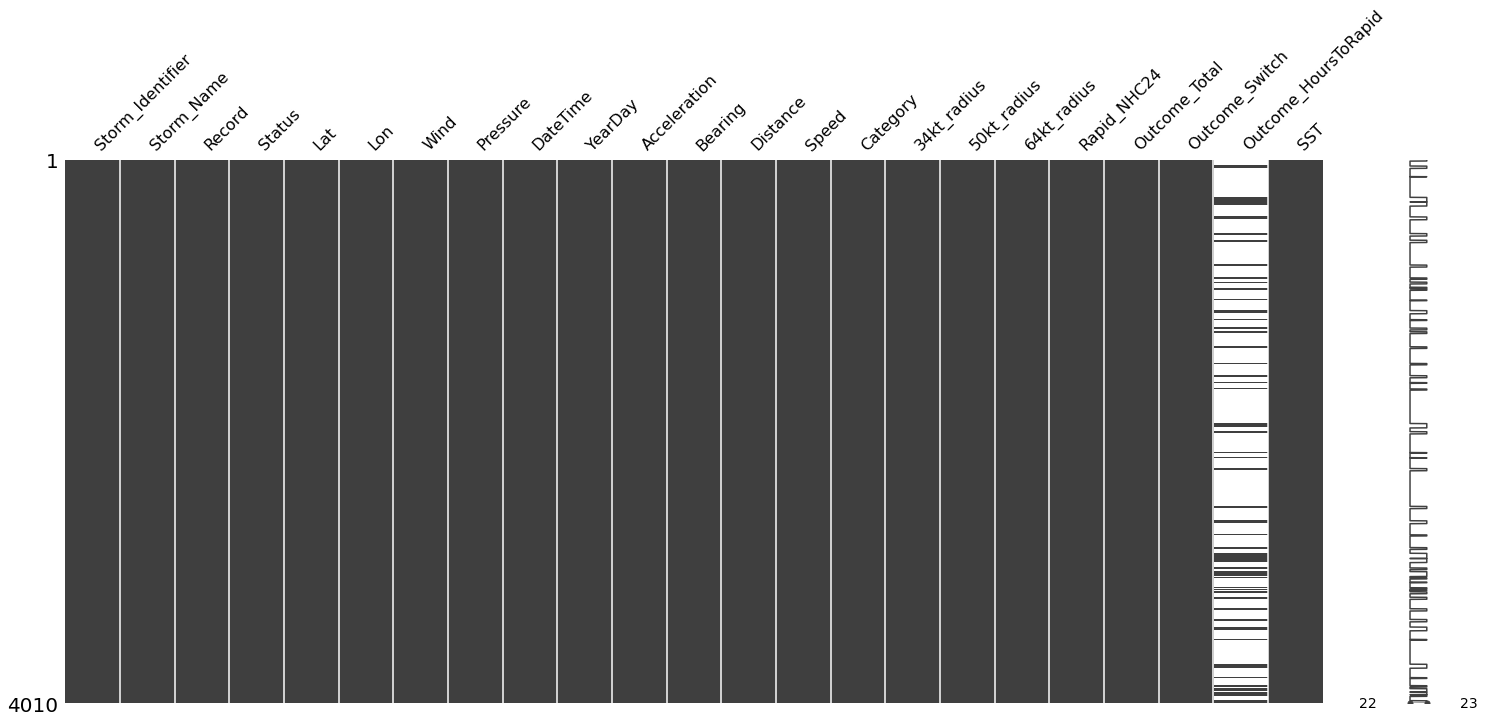

In [10]:
ms.matrix(dat);

### Data Variation and Distribution

Now let's get a 'feel' for the data by checking out the distributions. 

Note, now we need to be extremely careful to **only view the training data**, or else we could end up in machine learning hell. 👹 👹 

First, looking at the outcome variable, we calculate that about 10% of the observations have a positive outcome (i.e. there was an RI event within 24 hours)

In [11]:
# Percent of training data with positive outcome
train_y.sum() / len(train_y)

0.09577652144995012

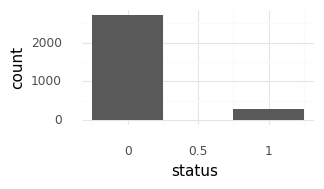

In [12]:
( # Display distribution of outcome variable Outcome_Total (training only, duh)
    ggplot(pd.DataFrame(dict(status=train_y)), aes(x="status")) +
    geom_histogram(bins=3) +
    theme_minimal() +
    theme(figure_size = (3,1.5))
).draw();

Next, we examine the numeric data columns. Here we find several skewed distributions that will need to be fixed in preprocessing.

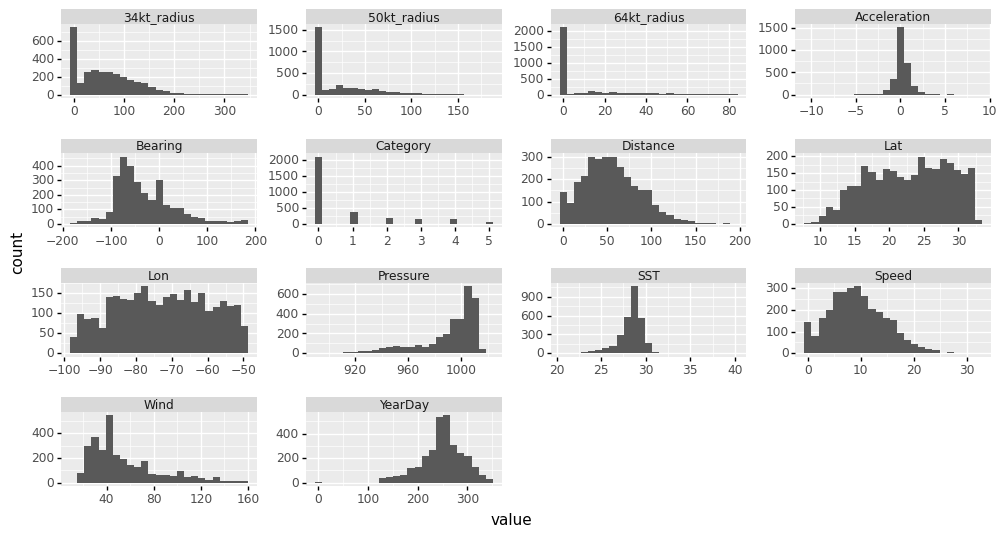

In [13]:
d = train_X[['YearDay','Lat','Lon','Wind','Pressure','Acceleration','Bearing','Distance','Speed','Category',
             '34kt_radius','50kt_radius','64kt_radius','SST']].melt() # melt numeric columns together

( # Display distribution of integer prediction variables
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(12,6), subplots_adjust={'wspace':0.25, 'hspace':0.75})
).draw();

### High Level Preprocessing
Several of the prediction variables have highly skewed distributions, something that could affect the accuracy of our model later. To fix this, we will take the natural log of these variables with the goal of 'unskewing' the distributions.

In [14]:
# list of variables we want to logify
to_Log = ['34kt_radius','50kt_radius','64kt_radius','Wind','Speed'] 
for col in to_Log: # iterate through the list and take the natural log of each column
    dat[f"ln_{col}"] = np.log(dat[col] + 1)
    
dat['Bearing'] = np.cos(np.radians(dat.Bearing))

## ➡️ <font color='steelblue'>Part 3:</font> Build the ML Pipeline ➡️

In [15]:
dat = dat[['Outcome_Total','ln_50kt_radius','Pressure','Acceleration','YearDay',
           'Speed','Wind','SST','Lat','Lon','Bearing']]

# Re-split data since we modified original dataframe
train_X, test_X, train_y, test_y = train_test_splitter(dat, set_seed)

In [16]:
# Set the folds index to ensure comparable samples, use 5 folds with set seed 202011
fold_generator = KFold(n_splits=5, shuffle=True,random_state=set_seed)

In [17]:
# Create Pipeline using built in pre-processing and MinMaxScaler, set default model to None
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [18]:
# Create model search space with tuning parameters using four models defined in assignment:
# Naive Bayes, K-nearest Neighbors, Decision Tree, Random Forest

search_space = [

    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,20,40,60,80,100,125,150,200,300,400,600,800,1000]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,4,6,8,10,12,14,16,18,20]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,4,6,8,10,12,14,16,18,20],
    'model__n_estimators':[250,500,750,1000,1250,1500,1750,2000,2250,2500]}

]

In [19]:
# define grid search function 
search = GridSearchCV(pipe, search_space, cv = fold_generator, scoring='roc_auc', n_jobs=4)

## 🎆 <font color='steelblue'>Part 4:</font> Run the Models 🎆

In [20]:
# Search through each model, this is where the magic happens 
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 20, 40, 60, 80, 100,
                                                 125, 150, 200, 300, 400, 600,
                                                 800, 1000]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                                               20]},
                         {'model': [RandomForestClassifier(max_depth=18,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                   

In [21]:
# Best score, per ROC AUC metric
search.best_score_

0.9448536521557175

In [22]:
# Model with the best parameters
search.best_params_

{'model': RandomForestClassifier(max_depth=18, n_estimators=1500),
 'model__max_depth': 18,
 'model__n_estimators': 1500}

In [23]:
# define a variable allowing us to use the estimator more later
rf_mod = search.best_estimator_

## 🔎 <font color='steelblue'>Part 5:</font> Idenitfy Best Model 🔎

In [24]:
# ROC AUC score for the best model (defined above) for the training data
m.roc_auc_score(train_y, rf_mod.predict_proba(train_X)[:,1])

1.0

In [25]:
# Accuracy score (percentage correct) for the best model on the training data
m.accuracy_score(train_y, rf_mod.predict(train_X))

1.0

The best preforming model was the Random Forest with depth 8 and 1250 estimators. Throughout my testing, the random forest model consistently preformed the best of the four, althought the tuning parameters often varied.

## 🔮 <font color='steelblue'>Part 6:</font> Model Interpretation 🔮

In [28]:
# Create Confusion Matrix
cf_matrix = confusion_matrix(test_y, rf_mod.predict(test_X))

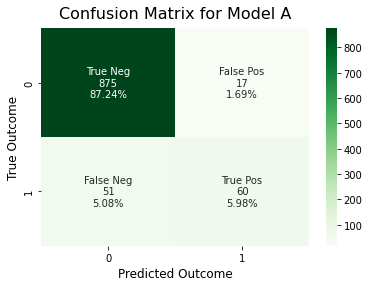

In [53]:
# Plot the Confusion Matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
ax.set_xlabel("Predicted Outcome", fontsize = 12)
ax.set_ylabel("True Outcome", fontsize = 12)
ax.set_title('Confusion Matrix for Model A', fontsize="16",pad=10);

### Permutation Importance

We remove one variable at a time (permutation) to back solve and find the most important predicition variable.

In [26]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)

In [27]:
# Organize permutation importance as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns, vi = vi['importances_mean'], std = vi['importances_std']))

# Generate confidence intervals (using t-stat of 2)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# Order variables from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,Acceleration,0.056734,0.000540,0.055654,0.057815
1,Lat,0.032391,0.001201,0.029989,0.034793
2,Pressure,0.027336,0.002365,0.022607,0.032066
3,Wind,0.024277,0.001208,0.021860,0.026693
4,ln_50kt_radius,0.018690,0.000489,0.017712,0.019667
5,SST,0.016162,0.001219,0.013724,0.018601
6,YearDay,0.015830,0.001357,0.013117,0.018543
7,Lon,0.015298,0.001722,0.011854,0.018741
8,Bearing,0.013302,0.000631,0.012040,0.014564
9,Speed,0.008646,0.000665,0.007316,0.009977


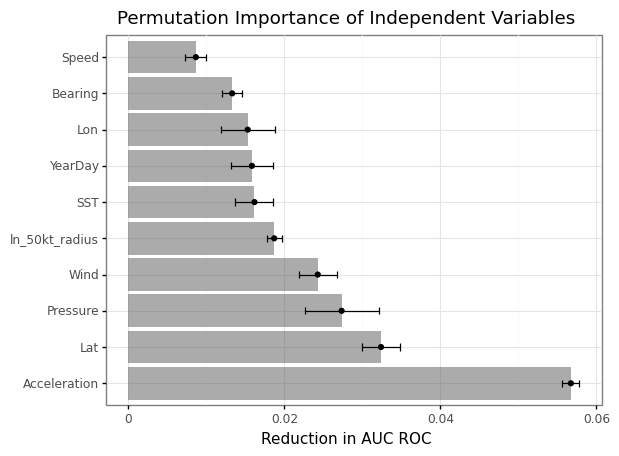

In [41]:
( # Plot permutation importance with error bars showing 95% confidence interval
    ggplot(vi_dat, aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    ggtitle('Permutation Importance of Independent Variables') +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
).draw();

### Partial Dependency

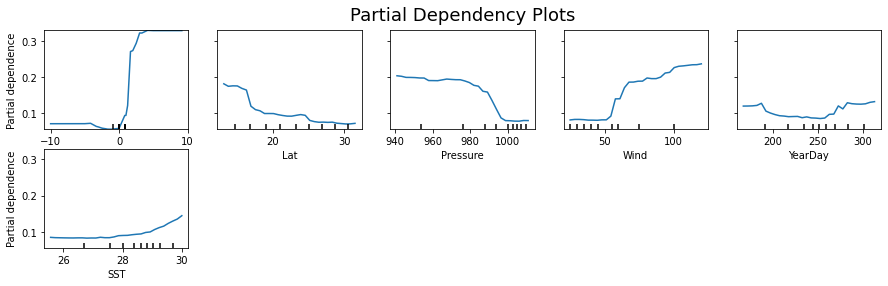

In [31]:
# Target specific features (those that matter the most, per permutation importance)
features = ['Acceleration','Lat','Pressure','Wind','YearDay','SST']

# Calculate the partial dependency and plot
fig, ax = plt.subplots(figsize=(15, 4))
plt.title('Partial Dependency Plots', fontsize=18, pad=10)
display = plot_partial_dependence(rf_mod, train_X, features,n_cols=5, n_jobs=4, grid_resolution=30,ax=ax)

### Partial Dependency Interaction

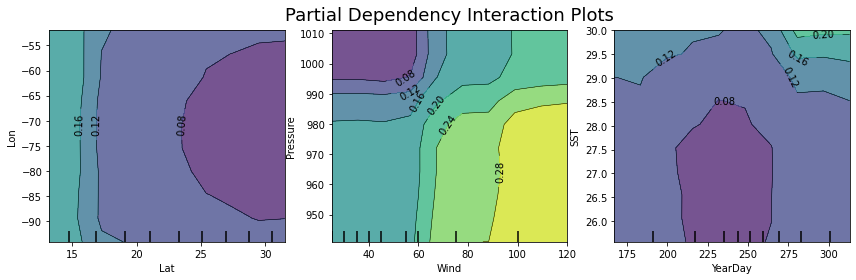

In [32]:
# Feed in the ineraction pairs as a nested list
interacted_features = [['Lat','Lon'],['Wind','Pressure'],['YearDay','SST']] 

# Calculate the partial dependency interaction and plot
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Partial Dependency Interaction Plots', fontsize=18, pad=10)
display = plot_partial_dependence(rf_mod, train_X, interacted_features, n_cols=3, n_jobs=4, grid_resolution=10,ax=ax)
fig.tight_layout()